In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
np.random.seed(42)

# Load Dataset

In [3]:
data_path = '../features_30_sec.csv'
orig_df = pd.read_csv(data_path)

labels = orig_df['label']

features_df = orig_df.drop(['filename','length','label'], axis=1)
features_df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


# Feature normalization

In [4]:
features_scaled = StandardScaler().fit_transform(features_df)
scaled_df = pd.DataFrame(features_scaled)

# Turn string labels to classes

In [5]:
label_map = {np.unique(labels)[i]:i for i in range(10)}
labels = labels.map(lambda i: label_map[i])

# Split into train and test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels, test_size=0.2)
print(f'Train test size: {X_train.shape[0]} rows, test set size: {X_test.shape[0]} rows')

Train test size: 800 rows, test set size: 200 rows


# Find optimal hyperparams

In [7]:
best_acc = -1
best_model = None

for n_est in [200,500,1000]:
    for mss in [2, 3, 5, 10]:
        print(f'Trying n_estimators = {n_est}, min_samples_split = {mss}')
        clf = GradientBoostingClassifier(n_estimators=n_est, min_samples_split=mss)
        clf.fit(X_train, y_train)
        
        preds = clf.predict(X_test)
        accuracy = accuracy_score(preds, y_test)
        print(f'Accuracy = {accuracy}')
        
        if accuracy > best_acc:
            best_acc = accuracy
            best_model = clf

print(f'Best accuracy = {best_acc}, best model = {best_model}')

Trying n_estimators = 200, min_samples_split = 2
Accuracy = 0.72
Trying n_estimators = 200, min_samples_split = 3
Accuracy = 0.72
Trying n_estimators = 200, min_samples_split = 5
Accuracy = 0.72
Trying n_estimators = 200, min_samples_split = 10
Accuracy = 0.74
Trying n_estimators = 500, min_samples_split = 2
Accuracy = 0.73
Trying n_estimators = 500, min_samples_split = 3
Accuracy = 0.72
Trying n_estimators = 500, min_samples_split = 5
Accuracy = 0.72
Trying n_estimators = 500, min_samples_split = 10
Accuracy = 0.73
Trying n_estimators = 1000, min_samples_split = 2
Accuracy = 0.715
Trying n_estimators = 1000, min_samples_split = 3
Accuracy = 0.715
Trying n_estimators = 1000, min_samples_split = 5
Accuracy = 0.705
Trying n_estimators = 1000, min_samples_split = 10
Accuracy = 0.725
Best accuracy = 0.74, best model = GradientBoostingClassifier(min_samples_split=10, n_estimators=200)


# Make predictions and assess accuracy

In [14]:
preds = best_model.predict(X_test)
accuracy = accuracy_score(preds, y_test)
confusion_mat = confusion_matrix(preds, y_test)

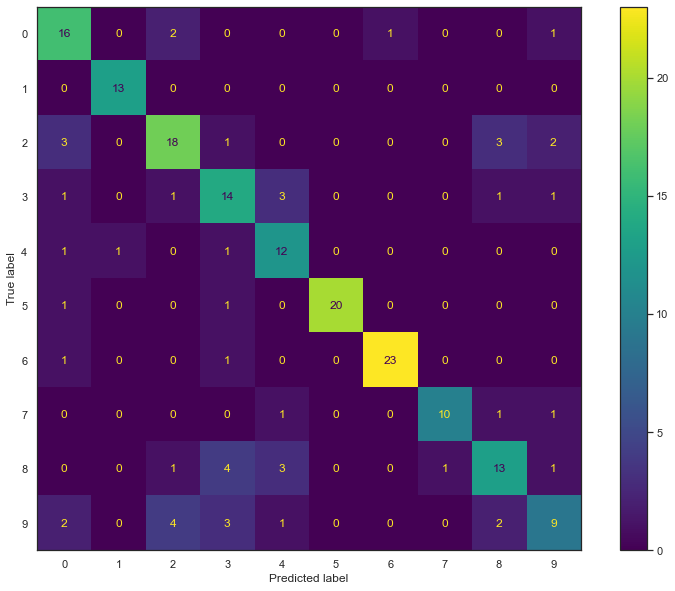

In [15]:
plot_confusion_matrix(best_model, X_test, y_test)

       label  accuracy
1  classical  1.000000
6      metal  0.920000
5       jazz  0.909091
0      blues  0.800000
4     hiphop  0.800000
7        pop  0.769231
2    country  0.666667
3      disco  0.666667
8     reggae  0.565217
9       rock  0.428571


<BarContainer object of 10 artists>

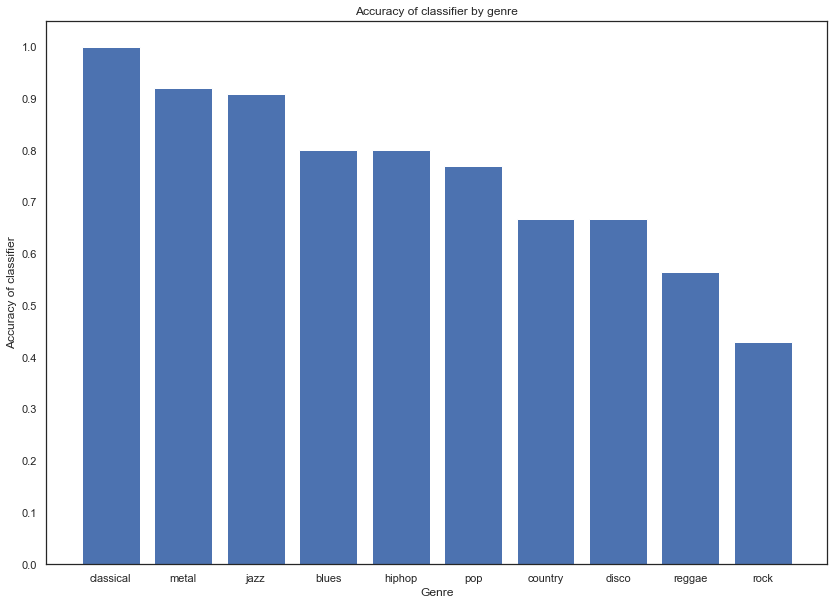

In [16]:
diag_entries = [confusion_mat[i,i] for i in range(len(confusion_mat))]
class_accuracy = diag_entries / np.sum(confusion_mat, axis=0)
label_names = list(label_map.keys())

acc_df = pd.DataFrame({'label':label_names, 'accuracy':class_accuracy})
acc_df = acc_df.sort_values(by='accuracy', ascending=False)
print(acc_df)

plt.xlabel('Genre')
plt.ylabel('Accuracy of classifier')

plt.yticks(np.arange(0,1.05,step=0.1))

plt.title('Accuracy of classifier by genre')
plt.bar(acc_df['label'], acc_df['accuracy'])

In [17]:
print(pd.Series(label_map))

blues        0
classical    1
country      2
disco        3
hiphop       4
jazz         5
metal        6
pop          7
reggae       8
rock         9
dtype: int64


<BarContainer object of 5 artists>

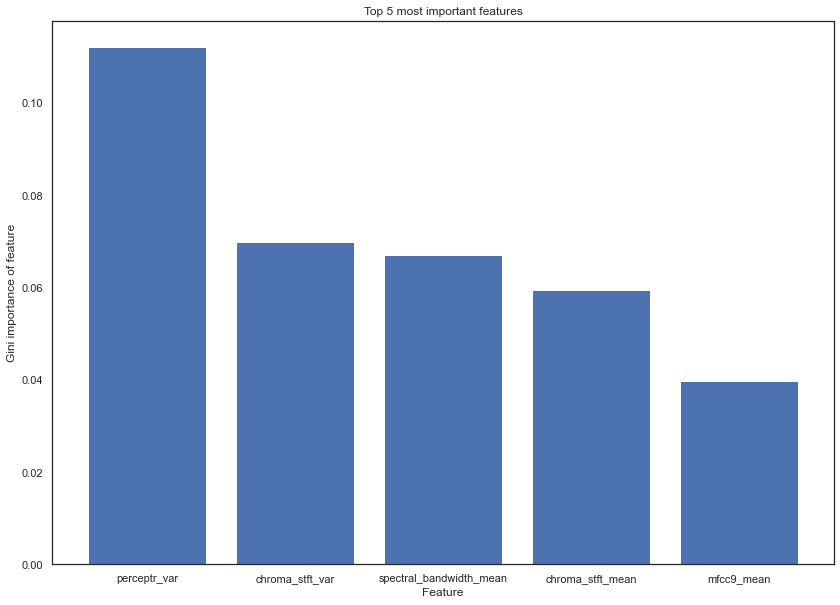

In [18]:
feature_importance = clf.feature_importances_
col_names = features_df.columns

importance_df = pd.DataFrame({'col':col_names, 'importance':feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.xlabel('Feature')
plt.ylabel('Gini importance of feature')
plt.title('Top 5 most important features')

plt.bar(importance_df.iloc[:5,0], importance_df.iloc[:5,1])

<AxesSubplot:xlabel='label'>

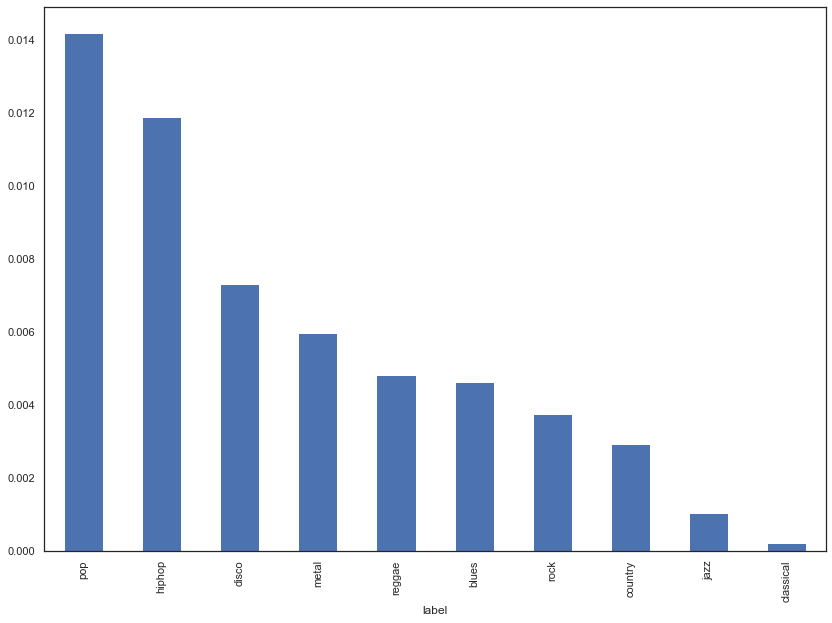

In [19]:
orig_df.groupby('label').mean()['perceptr_var'].sort_values(ascending=False).plot(kind='bar')